/tmp/ipykernel_50534/4170062728.py:16: RuntimeWarning: invalid value encountered in divide
  norm_img[:, :, c] = np.divide(img[:, :, c], rimg[:, :, c])


tfsdfsfs


/tmp/ipykernel_50534/4170062728.py:76: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  density = kde.gaussian_kde(data)


2023-08-08 19.38.42-1_seg_000_gauss.png


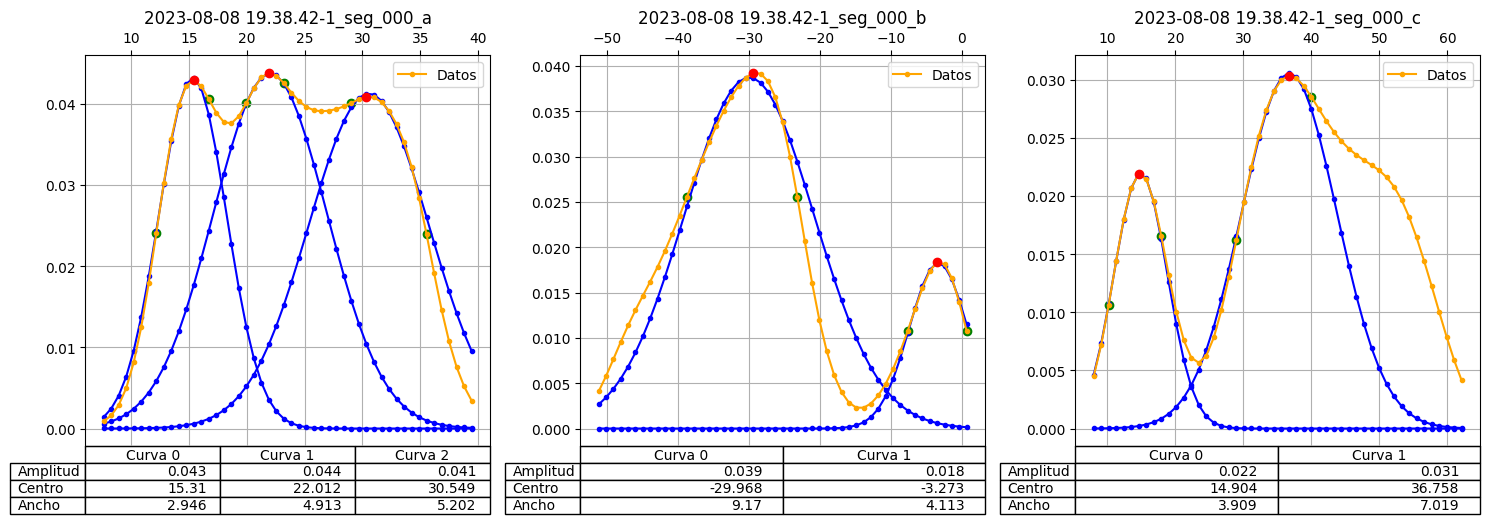

In [1]:
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
from skimage.color import rgb2lab, lab2lch
from matplotlib import pyplot as plt
from scipy.stats import kde
from scipy.signal import find_peaks
from scipy.optimize import curve_fit


def normalize_img(img, rimg):
    """normalize an image according to a reference image"""
    norm_img = np.zeros_like(img, dtype=np.float64)
    for c in range(3):
        norm_img[:, :, c] = np.divide(img[:, :, c], rimg[:, :, c])
        norm_img[:, :, c] = np.nan_to_num(norm_img[:, :, c], nan=0)

    norm_img = np.clip(norm_img, 0, 1)
    return norm_img


def rgb2labch(img):
    """converts an RGB space image to lab+lch CIE color space
    cv.COLOR_RGB2Lab
    https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html
    """
    lab_image = rgb2lab(img)
    L_channel = lab_image[:, :, 0]  # L channel
    a_channel = lab_image[:, :, 1]  # a channel
    b_channel = lab_image[:, :, 2]  # b channel

    lch_image = lab2lch(lab_image)
    c_channel = lch_image[:, :, 1]  # C channel
    h_channel = lch_image[:, :, 2]  # h channel
    return [L_channel, a_channel, b_channel, c_channel, h_channel]


def sd_by_elem(img):
    """calculate standard deviation by rgb pixel"""

    def std4elem(x):
        x_mean = np.mean(x[x > 0])
        n = len(x[x > 0])
        c = []
        for xi in x:
            c.append(np.sqrt(np.power(xi - x_mean, 2) / (n - 1)) if xi > 0 else 0)

        return np.array(c)

    img_r = img[:, :, 0].flatten()
    img_g = img[:, :, 1].flatten()
    img_b = img[:, :, 2].flatten()
    std_array = np.zeros_like(img)
    std_array[:, :, 0] = np.reshape(std4elem(img_r), img.shape[:-1])
    std_array[:, :, 1] = np.reshape(std4elem(img_g), img.shape[:-1])
    std_array[:, :, 2] = np.reshape(std4elem(img_b), img.shape[:-1])
    return std_array


def rm_bg2channel(chn, sd_val: float, sdimg = None):
    """remove the background of an image channel according to its standard deviation"""
    mask = (sdimg if sdimg is not None else chn) > sd_val
    chn_nobg = np.zeros_like(chn)
    chn_nobg[mask] = chn[mask]
    chn_nobg = np.clip(chn_nobg, 0, 1)

    return chn_nobg


def get_pdf(img):
    """get probability density function data"""
    data = np.around(img[img != 0], decimals=1)
    steps = (np.amax(data) + 1 - np.amin(data)) / 50
    rng = np.arange(np.amin(data), np.amax(data) + 1, step=steps)
    density = kde.gaussian_kde(data)
    density = density(rng)
    return data, rng, density


def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x - cen)**2 / (2 * wid**2))

src_dir = "./"
folder = Path(src_dir)

segmented = {
    '2023-08-08 19.38.42-1_seg_000.png': {'u': [0.0011, 0.0010, 0.0]},
  #  '2023-08-08 19.38.42-1_seg_003.png': {'u': [0.0005, 0.0004, 0.0]},
  #  '000_seg_013.png': {'u': [0.0008, 0.0004, 0.0]},
  #  '001_seg_005.png': {'u': [0.0006, 0.0004, 0.0]},
  #  '001_seg_017.png': {'u': [0.0012, 0.0011, 0.0]},
  #  '002_seg_000.png': {'u': [0.0009, 0.0007, 0.0]},
  #  '002_seg_003.png': {'u': [0.0008, 0.0008, 0.0]}
}


for num, data in segmented.items():
    # read only first two
    if num not in ('2023-08-08 19.38.42-1_seg_000.png', '2023-08-08 19.38.42-1_seg_003.png'):
        continue
    umb = data['u']
    ifp = folder / num
    ri = num.rsplit('.', maxsplit=1)[0]
    rifp = folder / rf'{ri}_ref.png'
    img = cv2.imread(str(ifp))
    assert img is not None, "file could not be read, check with os.path.exists()"
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    rimg = cv2.imread(str(rifp))
    assert rimg is not None, "file could not be read, check with os.path.exists()"
    rimg = cv2.cvtColor(rimg, cv2.COLOR_BGR2RGB)
    img_norm = normalize_img(img, rimg)
    
   
    
    keys = [ri, ri+'_ref', 'red', 'green', 'blue', 'normalized']
    cmaps = [None, None, 'Reds', 'Greens', 'Blues', None]
    
    img_sd = sd_by_elem(img_norm)

    img_sd_r = img_sd[:,:,0]
    img_sd_g = img_sd[:,:,1]
    img_sd_b = img_sd[:,:,2]
    
    img_nobgR = rm_bg2channel(img_norm[:, :, 0], umb[0], img_sd_r)
    img_nobgG = rm_bg2channel(img_norm[:, :, 1], umb[1], img_sd_g)
    img_nobgB = rm_bg2channel(img_norm[:, :, 2], umb[2], img_sd_b)
    imtest = np.zeros_like(img)
    imtest = imtest.astype(np.float64)
    imtest[:, :, 0] = img_nobgR
    imtest[:, :, 1] = img_nobgG
    imtest[:, :, 2] = img_nobgB
    for i in range(0, imtest.shape[0]):
        for j in range(0, imtest.shape[1]):
            px = imtest[i, j]
            if 0.0 in px:
                imtest[i, j] = np.zeros_like(imtest[i, j])
    
    labch = rgb2labch(imtest)
    keys += ["L", "a", "b", "c", "h"]
    cmaps += ['gray', 'coolwarm', 'coolwarm', 'viridis', 'hsv']

    print('tfsdfsfs')

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    chn = {0: 'a', 1:'b', 2:'c'}
    # the for is looping over:
    #     0: a channel
    #     1: b channel
    #     2: c channel
    for i, c in enumerate(labch[1:4]):
        desc = []
        # i != -1 because channel b moves in the negative quadrant,
        # while the other two move in the positive quadrant
        data, rng, dnst = get_pdf(c[c > 0.0]) if i != 1 else get_pdf(c[c < 0.0])

        # find peaks
        idxs, _ = find_peaks(dnst, distance=None)

        # find inflection points IP
        d2_dnst = np.diff(np.diff(dnst)) # Second derivative
        idx_ip = np.where(d2_dnst[:-1] * d2_dnst[1:] < 0)[0] + 1 # ids inflection points
        for index in idxs:
            xm = rng[index]
            ym = dnst[index]
            initial_guess = [ym, xm, 1.0]
            ls_ip = 0
            rs_ip = -1
            if idx_ip[idx_ip < index].size > 0:
                ls_ip = np.amax(idx_ip[idx_ip < index]) # left side inflection point
            if idx_ip[idx_ip > index].size > 0:
                rs_ip = np.amin(idx_ip[idx_ip > index]) # right side inflection point
            lx_inflexion = rng[ls_ip]
            ly_inflexion = dnst[ls_ip]
            rx_inflexion = rng[rs_ip]
            ry_inflexion = dnst[rs_ip]
            x = rng[ls_ip : rs_ip]
            y = dnst[ls_ip : rs_ip]
            if 0 in (x.size, y.size):
                print('Issues in', f'{num}_{chn[i]}')
                continue
            popt, pcov = curve_fit(gaussian, x, y, p0=initial_guess, maxfev=5000)
            desc.append([np.round(p, 3) for p in popt])
            ax[i].plot(rng, gaussian(rng, *popt), color='blue', marker='.')
            ax[i].scatter(xm, ym, color='red', zorder=2.5)
            ax[i].scatter(lx_inflexion, ly_inflexion, color='green')
            ax[i].scatter(rx_inflexion, ry_inflexion, color='green')
        
        ax[i].plot(rng, dnst, marker='.', color='orange', label='Datos')
        ax[i].grid(True)
        ax[i].legend()
        ax[i].set_title(f'{ri}_{chn[i]}')
        ax[i].xaxis.tick_top()

        t_rows = ["Amplitud", "Centro", "Ancho"]
        t_cols = [f"Curva {i}" for i in range(len(idxs))]
        # if len(desc) > 2:
        #     desc = [desc[0], desc[-1]]
        desc = np.array(desc).T
        ax[i].table(
            cellText=desc,
            rowLabels=t_rows,
            colLabels=t_cols,
            loc='bottom'
        )

    fig.subplots_adjust(left=0.2, bottom=0.5)
    plt.tight_layout()
    print(f'{ri}_gauss.png')
    fig.savefig(f'{ri}_gauss.png', bbox_inches='tight')
    plt.show()
    # input('Click and press enter to continue with next image')
    # clear_output(wait=False)
    # def intersection(x, param1, param2):
    #     y1 = gaussian(x, *param1)
    #     y2 = gaussian(x, *param2)
    #     return y1 - y2
    
    # x_range = (x1_peak, x2_peak)
    # cross = fsolve(intersection, sum(x_range) / 2, args=(popt, popt2))
    # print("Interseccion:", round(cross[0]))
    # plt.figure(figsize = (5, 5))
    # plt.axvline(cross, color='green', label='Umbral')